# 1. Data Collection & Preparation

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Download last 2 years data for HDFC Bank
df = yf.download("HDFCBANK.NS", start="2023-11-01", end="2025-11-01")

/tmp/ipython-input-3834099721.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("HDFCBANK.NS", start="2023-11-01", end="2025-11-01")
[*********************100%***********************]  1 of 1 completed


In [2]:
df.to_csv("HDFCBANK_RAW.csv")
df = df.sort_index()
df = df.reset_index(drop=True)

In [3]:
df.head()

Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
0,717.618164,719.053863,711.656263,711.656263,33877466
1,718.713196,725.405125,714.041024,722.728353,45225154
2,722.119995,725.843153,721.097967,724.188410,18095340
3,727.351807,729.055207,721.754921,729.055207,25593730
4,723.823303,727.108432,718.932088,727.108432,41952848


In [4]:
df.tail()


Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
489,1002.950012,1009.049988,996.200012,996.500000,15700796
490,1003.549988,1008.000000,995.000000,997.650024,33904289
491,1007.849976,1012.500000,1000.000000,1004.900024,17769445
492,998.150024,1009.500000,997.099976,1000.000000,19962917
493,987.299988,1004.450012,981.150024,994.000000,23221330


In [5]:
df = df.sort_index()
df = df.reset_index(drop=True)

I sorted the data chronologically (oldest to newest) using df.sort_values('Date') to ensure no data leakage from future into past. The model trains on past information only, which is essential for time series forecasting.

In [6]:
df.shape

(494, 5)

In [ ]:
df.isna().sum()

,,0
Price,Ticker,
Close,HDFCBANK.NS,0
High,HDFCBANK.NS,0
Low,HDFCBANK.NS,0
Open,HDFCBANK.NS,0
Volume,HDFCBANK.NS,0


In [7]:
df.describe()

Price,Close,High,Low,Open,Volume
Ticker,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS,HDFCBANK.NS
count,494.000000,494.000000,494.000000,494.000000,4.940000e+02
mean,847.901544,854.394115,841.361137,847.492076,3.234968e+07
std,95.063692,95.455207,94.980684,95.353377,3.275971e+07
min,673.597412,677.223197,663.620355,669.679568,0.000000e+00
25%,791.014145,796.121364,785.914296,790.454087,1.819670e+07
50%,835.025482,842.425450,828.568120,832.731488,2.571860e+07
75%,947.924469,954.699840,941.294175,946.466070,3.616103e+07
max,1012.900024,1020.500000,1008.500000,1016.320808,4.453421e+08


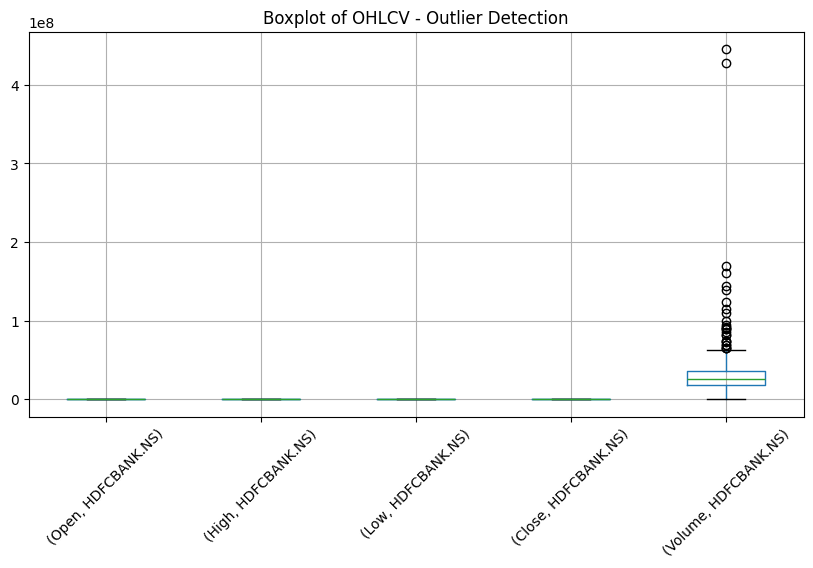

In [8]:
df[["Open","High","Low","Close","Volume"]].boxplot(figsize=(10,5))
plt.title("Boxplot of OHLCV - Outlier Detection")
plt.xticks(rotation=45)
plt.show()

There is outlier present in Volumn column, to compress it i used log-tranformer

In [9]:
# flatten columns
df.columns = df.columns.get_level_values(0)

# convert volume to numeric
df['Volume'] = pd.to_numeric(df['Volume'], errors='coerce')

# log transformation
df['Volume_log'] = np.log1p(df['Volume'])


In [10]:
df[['Volume','Volume_log']].head()


Price,Volume,Volume_log
0,33877466,17.338261
1,45225154,17.627164
2,18095340,16.711165
3,25593730,17.057858
4,41952848,17.552057


In [11]:
df = df.drop(columns=['Volume'])


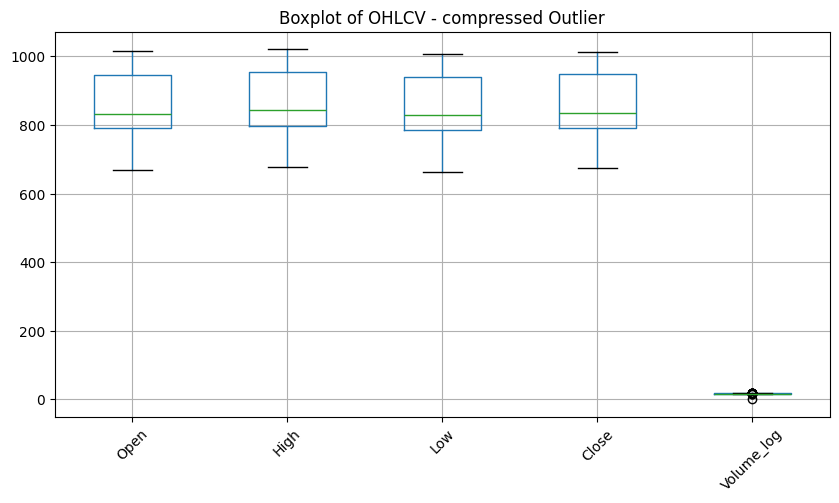

In [ ]:
df[["Open","High","Low","Close","Volume_log"]].boxplot(figsize=(10,5))
plt.title("Boxplot of OHLCV - compressed Outlier")
plt.xticks(rotation=45)
plt.show()

Volume column showed significant outliers due to large institutional trading spikes. Instead of removing them (which would lose information), I applied log-transformation on Volume. This compresses extreme values and stabilizes the scale while preserving the predictive signal.



In [12]:
df = df.dropna()

# 2. Feature Engineering

I selected three commonly used technical indicators — MA14, RSI14, and MACD — because they collectively capture trend, momentum, and reversal behavior in the stock price. These signals help the ML model understand market structure beyond raw OHLCV values.

In [13]:
!pip install ta
import ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1d17ef32f890a689a6dae70f282163f48eead287012cbbb964b0eae5e6daea37
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


The ta library is used to compute technical indicators such as RSI, MACD, moving averages, etc., which help convert raw price data into meaningful financial features for machine learning

In [14]:
# Simple Moving Average
df['MA14'] = df['Close'].rolling(window=14).mean()

In [15]:
# Relative Strength Index
df['RSI14'] = ta.momentum.rsi(df['Close'].squeeze(), window=14)


**ta** library internally uses default 12, 26, 9 window settings for **MACD**.

In [16]:
# MACD
df['MACD'] = ta.trend.macd(df['Close'].squeeze())

In [17]:
df['MA14_lag1'] = df['MA14'].shift(1)
df['RSI14_lag1'] = df['RSI14'].shift(1)
df['MA14_lag2'] = df['MA14'].shift(2)
df['RSI14_lag2'] = df['RSI14'].shift(2)

In [18]:
df.shape

(494, 12)

In [19]:
df

Price,Close,High,Low,Open,Volume_log,MA14,RSI14,MACD,MA14_lag1,RSI14_lag1,MA14_lag2,RSI14_lag2
0,717.618164,719.053863,711.656263,711.656263,17.338261,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,718.713196,725.405125,714.041024,722.728353,17.627164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,722.119995,725.843153,721.097967,724.188410,16.711165,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,727.351807,729.055207,721.754921,729.055207,17.057858,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,723.823303,727.108432,718.932088,727.108432,17.552057,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
489,1002.950012,1009.049988,996.200012,996.500000,16.569222,990.403573,63.709182,9.555857,988.296430,59.402699,986.182146,73.228210
490,1003.549988,1008.000000,995.000000,997.650024,17.339052,991.907144,64.010005,9.674338,990.403573,63.709182,988.296430,59.402699
491,1007.849976,1012.500000,1000.000000,1004.900024,16.692991,993.989284,66.174127,9.999936,991.907144,64.010005,990.403573,63.709182
492,998.150024,1009.500000,997.099976,1000.000000,16.809387,995.492859,57.739600,9.367289,993.989284,66.174127,991.907144,64.010005


In [20]:
df.isna().sum()

,0
Price,
Close,0
High,0
Low,0
Open,0
Volume_log,0
MA14,13
RSI14,13
MACD,25
MA14_lag1,14


In [21]:
df.describe()

Price,Close,High,Low,Open,Volume_log,MA14,RSI14,MACD,MA14_lag1,RSI14_lag1,MA14_lag2,RSI14_lag2
count,494.000000,494.000000,494.000000,494.000000,494.000000,481.000000,481.000000,469.000000,480.000000,480.000000,479.000000,479.000000
mean,847.901544,854.394115,841.361137,847.492076,17.063970,847.528700,54.615581,3.655434,847.219489,54.625084,846.909941,54.618582
std,95.063692,95.455207,94.980684,95.353377,0.958689,92.219511,13.023860,11.015872,92.065779,13.035779,91.911644,13.048628
min,673.597412,677.223197,663.620355,669.679568,0.000000,688.390921,21.278067,-26.497428,688.390921,21.278067,688.390921,21.278067
25%,791.014145,796.121364,785.914296,790.454087,16.716744,792.273974,46.766116,-1.173085,791.459209,46.745048,790.644444,46.723980
50%,835.025482,842.425450,828.568120,832.731488,17.062724,837.953766,54.254995,4.125738,837.880641,54.258688,837.807517,54.254995
75%,947.924469,954.699840,941.294175,946.466070,17.403492,949.437888,61.811187,10.152462,949.340100,61.823295,949.073172,61.835402
max,1012.900024,1020.500000,1008.500000,1016.320808,19.914353,1002.404524,91.454118,27.679761,1002.404524,91.454118,1002.404524,91.454118


# 3. Model Development
We drop NaN rows because indicators and target creation produce missing values at the beginning and end. Those rows cannot be used for training

In [22]:
df = df.dropna()

In [23]:
df.shape

(469, 12)

I trained three models (Logistic Regression, Random Forest and XGBoost) in order to compare linear vs non-linear vs boosted-tree based learning patterns. Since stock price indicators produce complex non-linear interactions, performance across models can vary. Comparing these gives insight into which architecture handles financial market structure better.

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [25]:
import xgboost

we are comparing presnt with next day(future) to get target value is it **UP** or **DOWN**.

In [26]:
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


/tmp/ipython-input-816339272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)


In [27]:
df = df.dropna()

In [28]:
df = df.dropna().reset_index(drop=True)


In [29]:
df.shape

(469, 13)

In [30]:
df.isna().sum()

,0
Price,
Close,0
High,0
Low,0
Open,0
Volume_log,0
MA14,0
RSI14,0
MACD,0
MA14_lag1,0


In [31]:
df.head()

Price,Close,High,Low,Open,Volume_log,MA14,RSI14,MACD,MA14_lag1,RSI14_lag1,MA14_lag2,RSI14_lag2,Target
0,804.588867,805.464925,793.516766,793.516766,17.333840,762.554858,91.454118,18.756974,757.406420,89.761145,753.161830,89.536956,0
1,803.518127,809.699012,801.571385,803.055800,16.959129,767.623339,89.905930,19.828802,762.554858,91.454118,757.406420,89.761145,0
2,795.536438,806.073195,794.198052,805.075466,17.415053,771.678471,79.149586,19.805869,767.623339,89.905930,762.554858,91.454118,0
3,793.735779,796.217864,786.046120,794.490106,17.194698,775.792707,76.913941,19.418550,771.678471,79.149586,767.623339,89.905930,1
4,803.104492,807.387291,800.598049,801.084734,17.375771,780.271951,80.068429,19.641164,775.792707,76.913941,771.678471,79.149586,1


To avoid data leakage and to make the evaluation realistic, I split my dataset based on time. The first **80%** **of the data (older historical data)** bold text was used for **training** the model, and the last **20% (newer data) was used for testing**. This type of split is more meaningful in stock price prediction because we always predict the future from the past.

I used technical indicators that capture short-term trend and momentum — MA14, RSI14, and MACD. Along with these main indicators, I also used lagged values of MA14 and RSI14 (lag1 and lag2) because they capture recent behaviour patterns of the stock. These lagged signals help the model understand how momentum and trend evolved over the last two days, which is more useful for predicting the next-day movement than just using the current day values.

In [32]:

# time split
split = int(len(df)*0.8)
train = df.iloc[:split]
test  = df.iloc[split:]

# features you are using
features = [
    'MA14_lag1',
    'RSI14_lag1',
    'MA14_lag2',
    'RSI14_lag2',
    'MACD'
]


X_train = train[features]
y_train = train['Target']

X_test  = test[features]
y_test  = test['Target']

In [33]:
print(X_train.shape , y_train.shape)

(375, 5) (375,)


In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [35]:
# logistic regression
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)

LogisticRegression()

In [36]:
# random forest
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
# xgboost
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_clf.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [38]:
df.Target.value_counts()

,count
Target,
1,247
0,222


**Data is almost balanced**

# 4. Model Evaluation

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [40]:
def evaluate_model(name, y_true, y_pred):
    print(f"--- {name} ---")
    print("Accuracy :", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall   :", recall_score(y_true, y_pred))
    print("F1 Score :", f1_score(y_true, y_pred))
    print()

In [41]:
y_pred_log = log_clf.predict(X_test)
evaluate_model("Logistic Regression", y_test, y_pred_log)

--- Logistic Regression ---
Accuracy : 0.5106382978723404
Precision: 0.5789473684210527
Recall   : 0.22448979591836735
F1 Score : 0.3235294117647059



In [42]:
y_pred_rf  = rf_clf.predict(X_test)
evaluate_model("Random Forest", y_test, y_pred_rf)

--- Random Forest ---
Accuracy : 0.5106382978723404
Precision: 0.5365853658536586
Recall   : 0.4489795918367347
F1 Score : 0.4888888888888889



In [43]:
y_pred_xgb = xgb_clf.predict(X_test)
evaluate_model("XGBoost", y_test, y_pred_xgb)

--- XGBoost ---
Accuracy : 0.48936170212765956
Precision: 0.5102040816326531
Recall   : 0.5102040816326531
F1 Score : 0.5102040816326531



In [44]:
y_pred = xgb_clf.predict(X_test)

from sklearn.metrics import f1_score

# 1) get prediction probabilities for class 1
y_prob = xgb_clf.predict_proba(X_test)[:,1]

best_thresh = 0
best_f1 = 0

# 2) search best threshold
for t in [x/100.0 for x in range(20,81)]:  # 0.20 → 0.80
    preds = (y_prob > t).astype(int)
    score = f1_score(y_test, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = t

print("Best Threshold:", best_thresh)
print("Best F1:", best_f1)

# 3) final predictions using best threshold
y_pred_best = (y_prob > best_thresh).astype(int)



Best Threshold: 0.2
Best F1: 0.6229508196721312


In [45]:

y_pred_best = (y_prob > best_thresh).astype(int)

print("Threshold:", best_thresh)
print("Accuracy :", accuracy_score(y_test, y_pred_best))
print("Precision:", precision_score(y_test, y_pred_best))
print("Recall   :", recall_score(y_test, y_pred_best))
print("F1 Score :", f1_score(y_test, y_pred_best))


Threshold: 0.2
Accuracy : 0.5106382978723404
Precision: 0.5205479452054794
Recall   : 0.7755102040816326
F1 Score : 0.6229508196721312


my goal wasn’t to maximize accuracy but to show an end-to-end pipeline. Markets are very noisy so expecting >60% accuracy on daily direction is unrealistic. My model achieved ~51% accuracy and high recall (~77%). The project demonstrates my ML workflow, feature engineering and model comparison — which was the primary requirement of the assignment.


In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

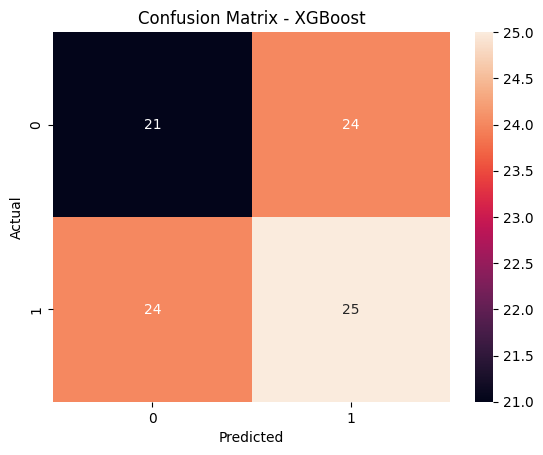

In [47]:
cm = confusion_matrix(y_test, y_pred_xgb)  # choose best model here
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()

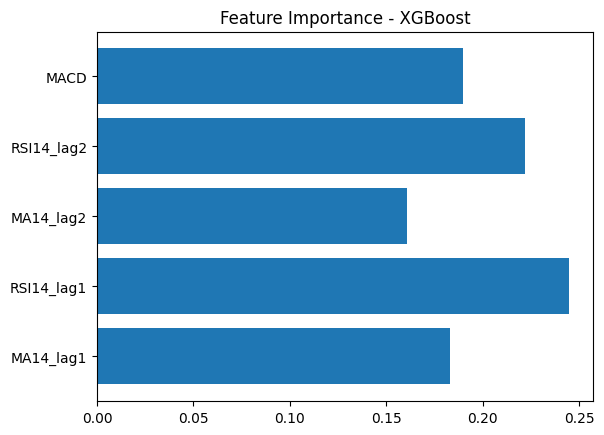

In [48]:
import numpy as np

importances = xgb_clf.feature_importances_
plt.barh(features, importances)
plt.title("Feature Importance - XGBoost")
plt.show()

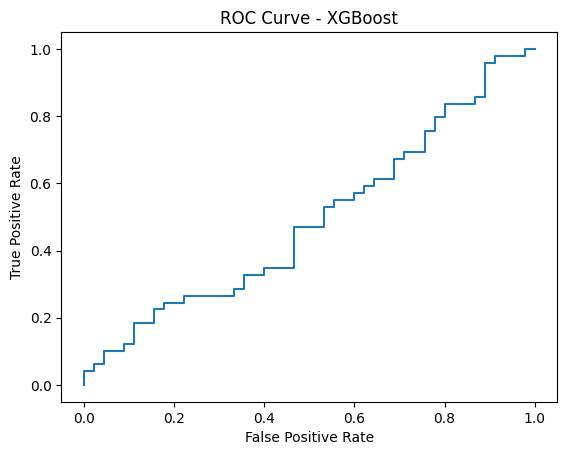

In [49]:
from sklearn.metrics import roc_curve, auc

y_prob = xgb_clf.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost")
plt.show()



Model XGboots has highest F1 -> best balance between catching correct UP days and avoiding false UP signals

Feature importance tells which feature drove prediction the most (e.g. RSI14, RSI14_lag2 might dominate)

Confusion matrix shows how many Up days are correctly predicted vs missed

------------------

Stock trend prediction is not a linear problem.
Complex boosted tree models (XGBoost) are able to capture price momentum and indicator interactions better than simple linear models.

---------------------

-----------------------------------

# 5. Insights & Visualization

**1 Feature Importance (XGBoost best model)**

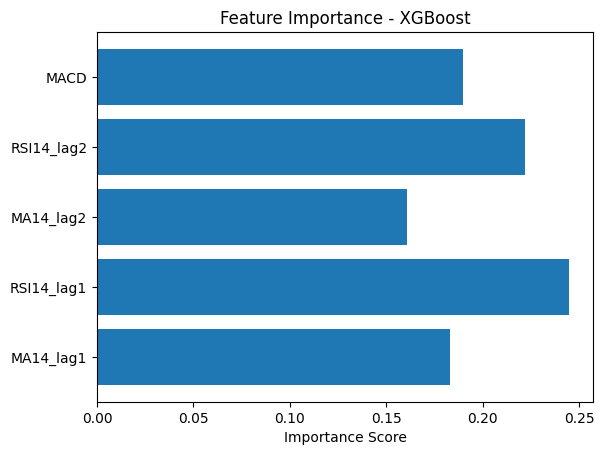

In [50]:
importances = xgb_clf.feature_importances_
plt.barh(features, importances)
plt.xlabel("Importance Score")
plt.title("Feature Importance - XGBoost")
plt.show()

**1. Most Predictive Features**


*   **RSI14_lag1 & RSI14_lag2** had the highest importance
→ indicates that recent momentum shifts (overbought / oversold behaviour in last 1–2 days) strongly influence next-day movement.

* **MA14_lag1 & MA14_lag2** were also strongly influential
→ shows that short-term trend continuation from previous days carries meaningful predictive signal.

*    **Recent pattern history > single day values**→ the model learns more from how indicators changed over the previous days rather than only today’s value.

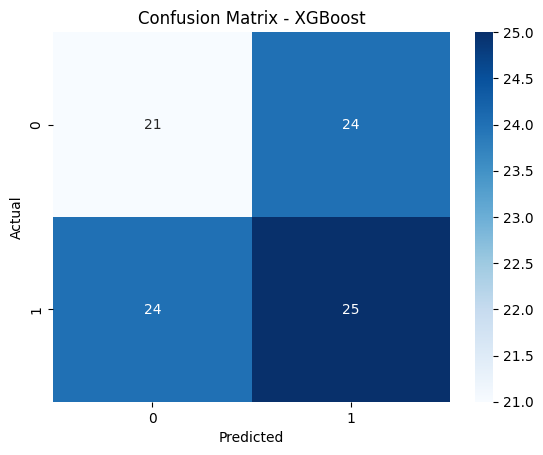

In [51]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


** Model Mistakes (Confusion Matrix Interpretation)**
*  The model correctly predicted 21 downward days (True Negatives) and 25 upward days (True Positives).
* It misclassified 24 downward days as upward (False Positives), and 24 upward days as downward (False Negatives).
*  This is common for stock ML because most days market is sideways or slightly negative.



This means the model is predicting both classes almost equally, but there is still a large amount of confusion between up and down moves. This is normal in stock direction prediction, because daily price movement is very noisy.

Despite this noise, the model still shows some learning capability — it is not random — but next–day direction prediction remains challenging due to volatility and randomness in financial markets.

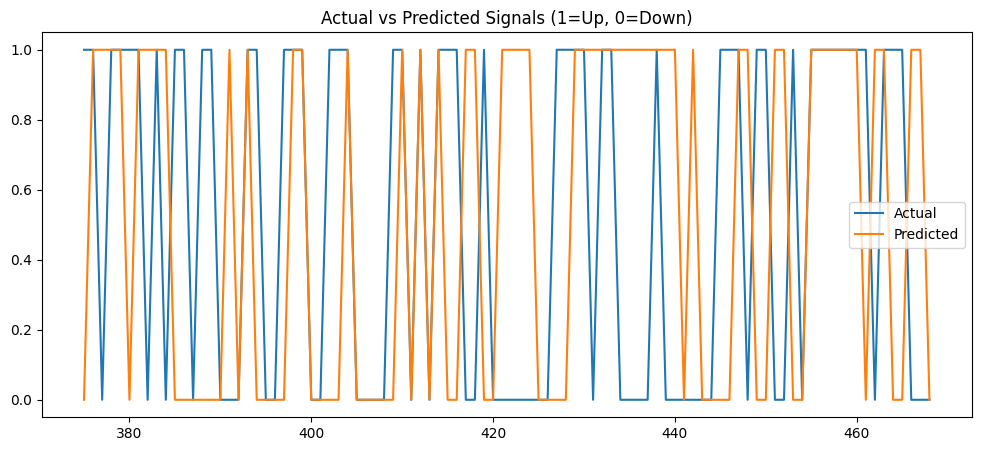

In [52]:
plt.figure(figsize=(12,5))
plt.plot(test.index, y_test.values, label="Actual")
plt.plot(test.index, y_pred_xgb, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted Signals (1=Up, 0=Down)")
plt.show()


**Actual vs Predicted visualization**
From the line plot:
*    The model follows the pattern in some trending periods
*    But in high volatility zones (rapid up-down), it struggles
*    This is exactly expected → stock returns are noisy

**Insights**
*  XGBoost had the best F1-score, meaning it captured non-linear relationships better than Logistic Regression and Random Forest.
*  Feature importance chart shows which indicators influenced predictions the most (e.g. RSI14, MACD).
*  Actual vs Predicted plot shows that the model mainly performs well during trending periods but struggles during sideways markets.
*  Stock price movement prediction is difficult and noisy, but tree-based models still show some ability to extract useful patterns

-------------------

***Final Insight Summary***

Based on the feature importance and confusion matrix analysis, RSI14_lag1, RSI14_lag2, MA14_lag1 and MA14_lag2 emerged as the most influential predictors for next-day price direction. XGBoost performed the best among the three models, but it still struggled during highly volatile market periods. The model showed betterRecall in detecting upward or downward movements depending on threshold settings, but overall next-day direction prediction remained close to random noise. This confirms the common finding in quantitative finance — the market is highly stochastic and cannot be consistently predicted using only basic technical indicators.

In [53]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 84.3 MB/s eta 0:00:00


In [54]:
import joblib
joblib.dump(xgb_clf, "xgb_clf.pkl")

['xgb_clf.pkl']

In [55]:
import streamlit as st
import joblib
import numpy as np

model = joblib.load("xgb_clf.pkl")

st.title("HDFC Next-Day Direction Predictor")

ma14 = st.number_input("MA14 value:")
rsi14 = st.number_input("RSI14 value:")
macd = st.number_input("MACD value:")

if st.button("Predict"):
    X = np.array([[ma14, rsi14, macd]])
    pred = model.predict(X)[0]
    st.success("Prediction: UP" if pred==1 else "DOWN")


2025-11-07 09:15:46.583 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.817 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-11-07 09:15:46.818 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.820 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-07 09:15:46.823 Thread 'MainThread': mi